In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = 'datas'

train_data_path = join(data_dir, 'sales_train.csv')
sub_data_path = join(data_dir, 'test.csv')      # ÌÖåÏä§Ìä∏, Ï¶â submission Ïãú ÏÇ¨Ïö©Ìï† Îç∞Ïù¥ÌÑ∞ Í≤ΩÎ°ú

print(train_data_path)
print(sub_data_path)

datas/sales_train.csv
datas/test.csv


In [3]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (2935849, 6)
sub data dim : (214200, 3)


# 1. Îç∞Ïù¥ÌÑ∞ ÏÇ¥Ìé¥Î≥¥Í∏∞   
   
ID-  ÌÖåÏä§Ìä∏ ÏÑ∏Ìä∏ ÎÇ¥ÏóêÏÑú (Shop, Item) ÌäúÌîåÏùÑ ÎÇòÌÉÄÎÇ¥Îäî Id   
shop_id- ÏÉÅÏ†êÏùò Í≥†Ïú† ÏãùÎ≥ÑÏûê   
item_id- ÏÉÅÌíàÏùò Í≥†Ïú† ÏãùÎ≥ÑÏûê   
item_category_id- Ìï≠Î™© Ïπ¥ÌÖåÍ≥†Î¶¨Ïùò Í≥†Ïú† ÏãùÎ≥ÑÏûê   
item_cnt_day- ÌåêÎß§ Îêú Ï†úÌíà ÏàòÏûÖÎãàÎã§. Ïù¥ Ï∏°Ï†ï Í∞íÏùò ÏõîÎ≥Ñ Í∏àÏï°ÏùÑ ÏòàÏ∏°ÌïòÍ≥† ÏûàÏäµÎãàÎã§.   
item_price- ÏÉÅÌíàÏùò ÌòÑÏû¨ Í∞ÄÍ≤©   
date  -dd / mm / yyyy ÌòïÏãùÏùò ÎÇ†Ïßú   
date_block_num- Ìé∏ÏùòÎ•º ÏúÑÌï¥ ÏÇ¨Ïö©ÎêòÎäî Ïó∞ÏÜç Îêú Ïõî Î≤àÌò∏. 2013 ÎÖÑ 1 ÏõîÏùÄ 0, 2013 ÎÖÑ 2 ÏõîÏùÄ 1, ..., 2015 ÎÖÑ 10 ÏõîÏùÄ 33ÏûÖÎãàÎã§.   
item_name-  Ìï≠Î™© Ïù¥Î¶Ñ   
shop_name- ÏÉÅÏ†ê Ïù¥Î¶Ñ   
item_category_name- Ìï≠Î™© Ïπ¥ÌÖåÍ≥†Î¶¨ Ïù¥Î¶Ñ   

In [4]:
del data['date']

del data['item_price']

In [5]:
sub_id = sub['ID']
del sub['ID']

sub['date_block_num'] = 34

In [6]:
print(data.columns)

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_day'], dtype='object')


In [7]:
print(sub.columns)

Index(['shop_id', 'item_id', 'date_block_num'], dtype='object')


In [8]:
data.head()

date_block_num  shop_id  item_id  item_cnt_day
0               0       59    22154           1.0
1               0       25     2552           1.0
2               0       25     2552          -1.0
3               0       25     2554           1.0
4               0       25     2555           1.0

In [9]:
sub.head()

shop_id  item_id  date_block_num
0        5     5037              34
1        5     5320              34
2        5     5233              34
3        5     5232              34
4        5     5268              34

<AxesSubplot:>

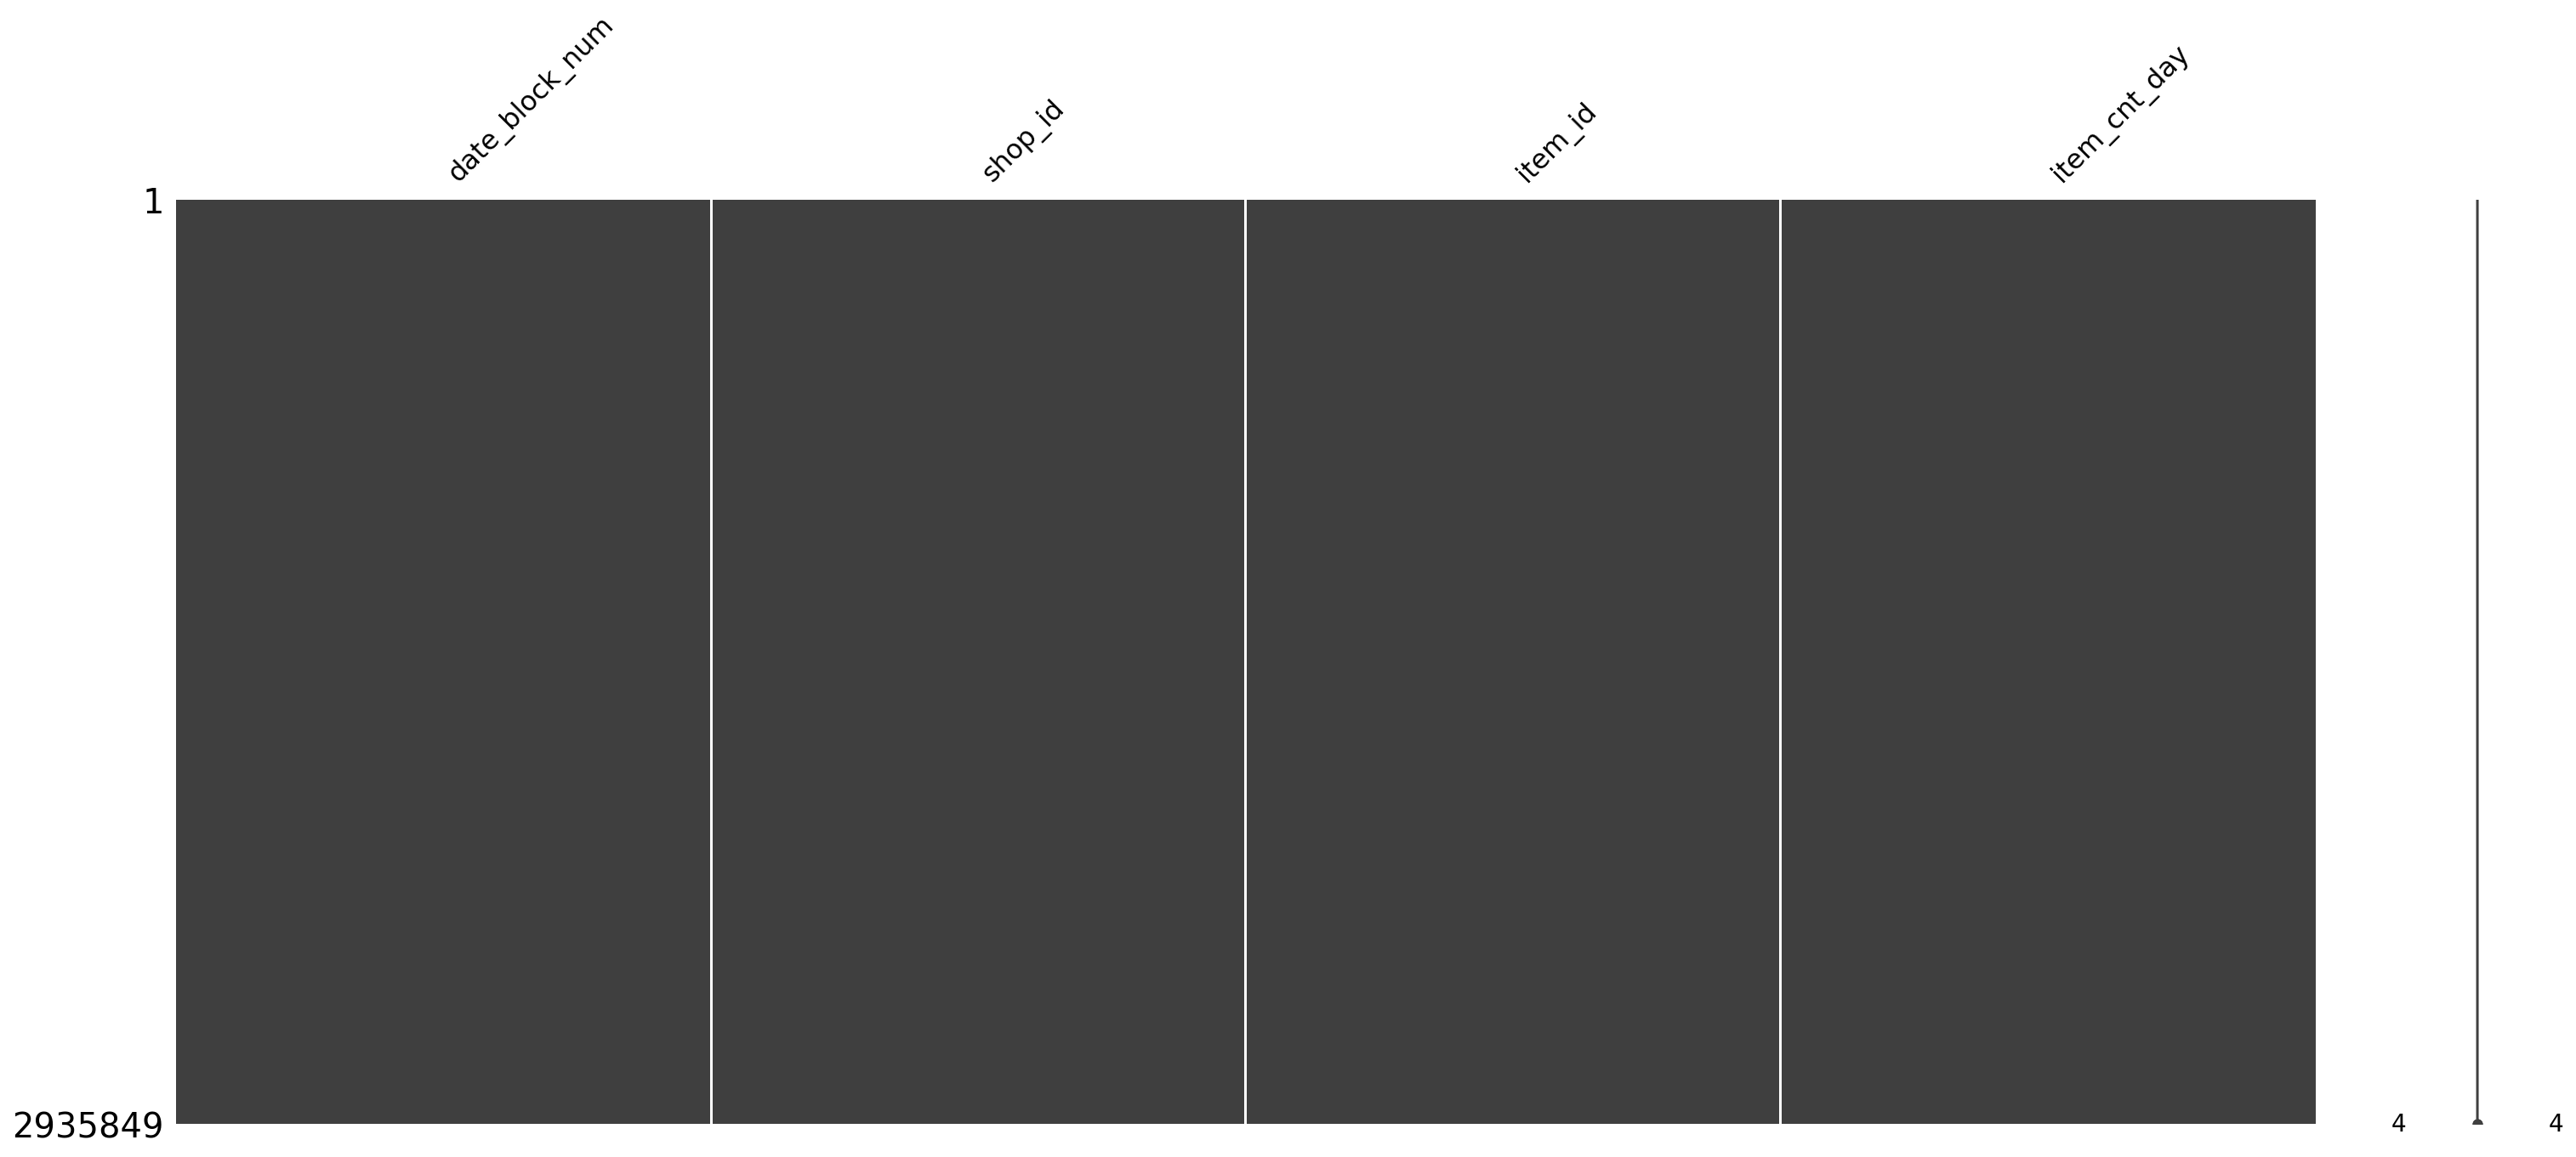

In [10]:
msno.matrix(data)

<AxesSubplot:>

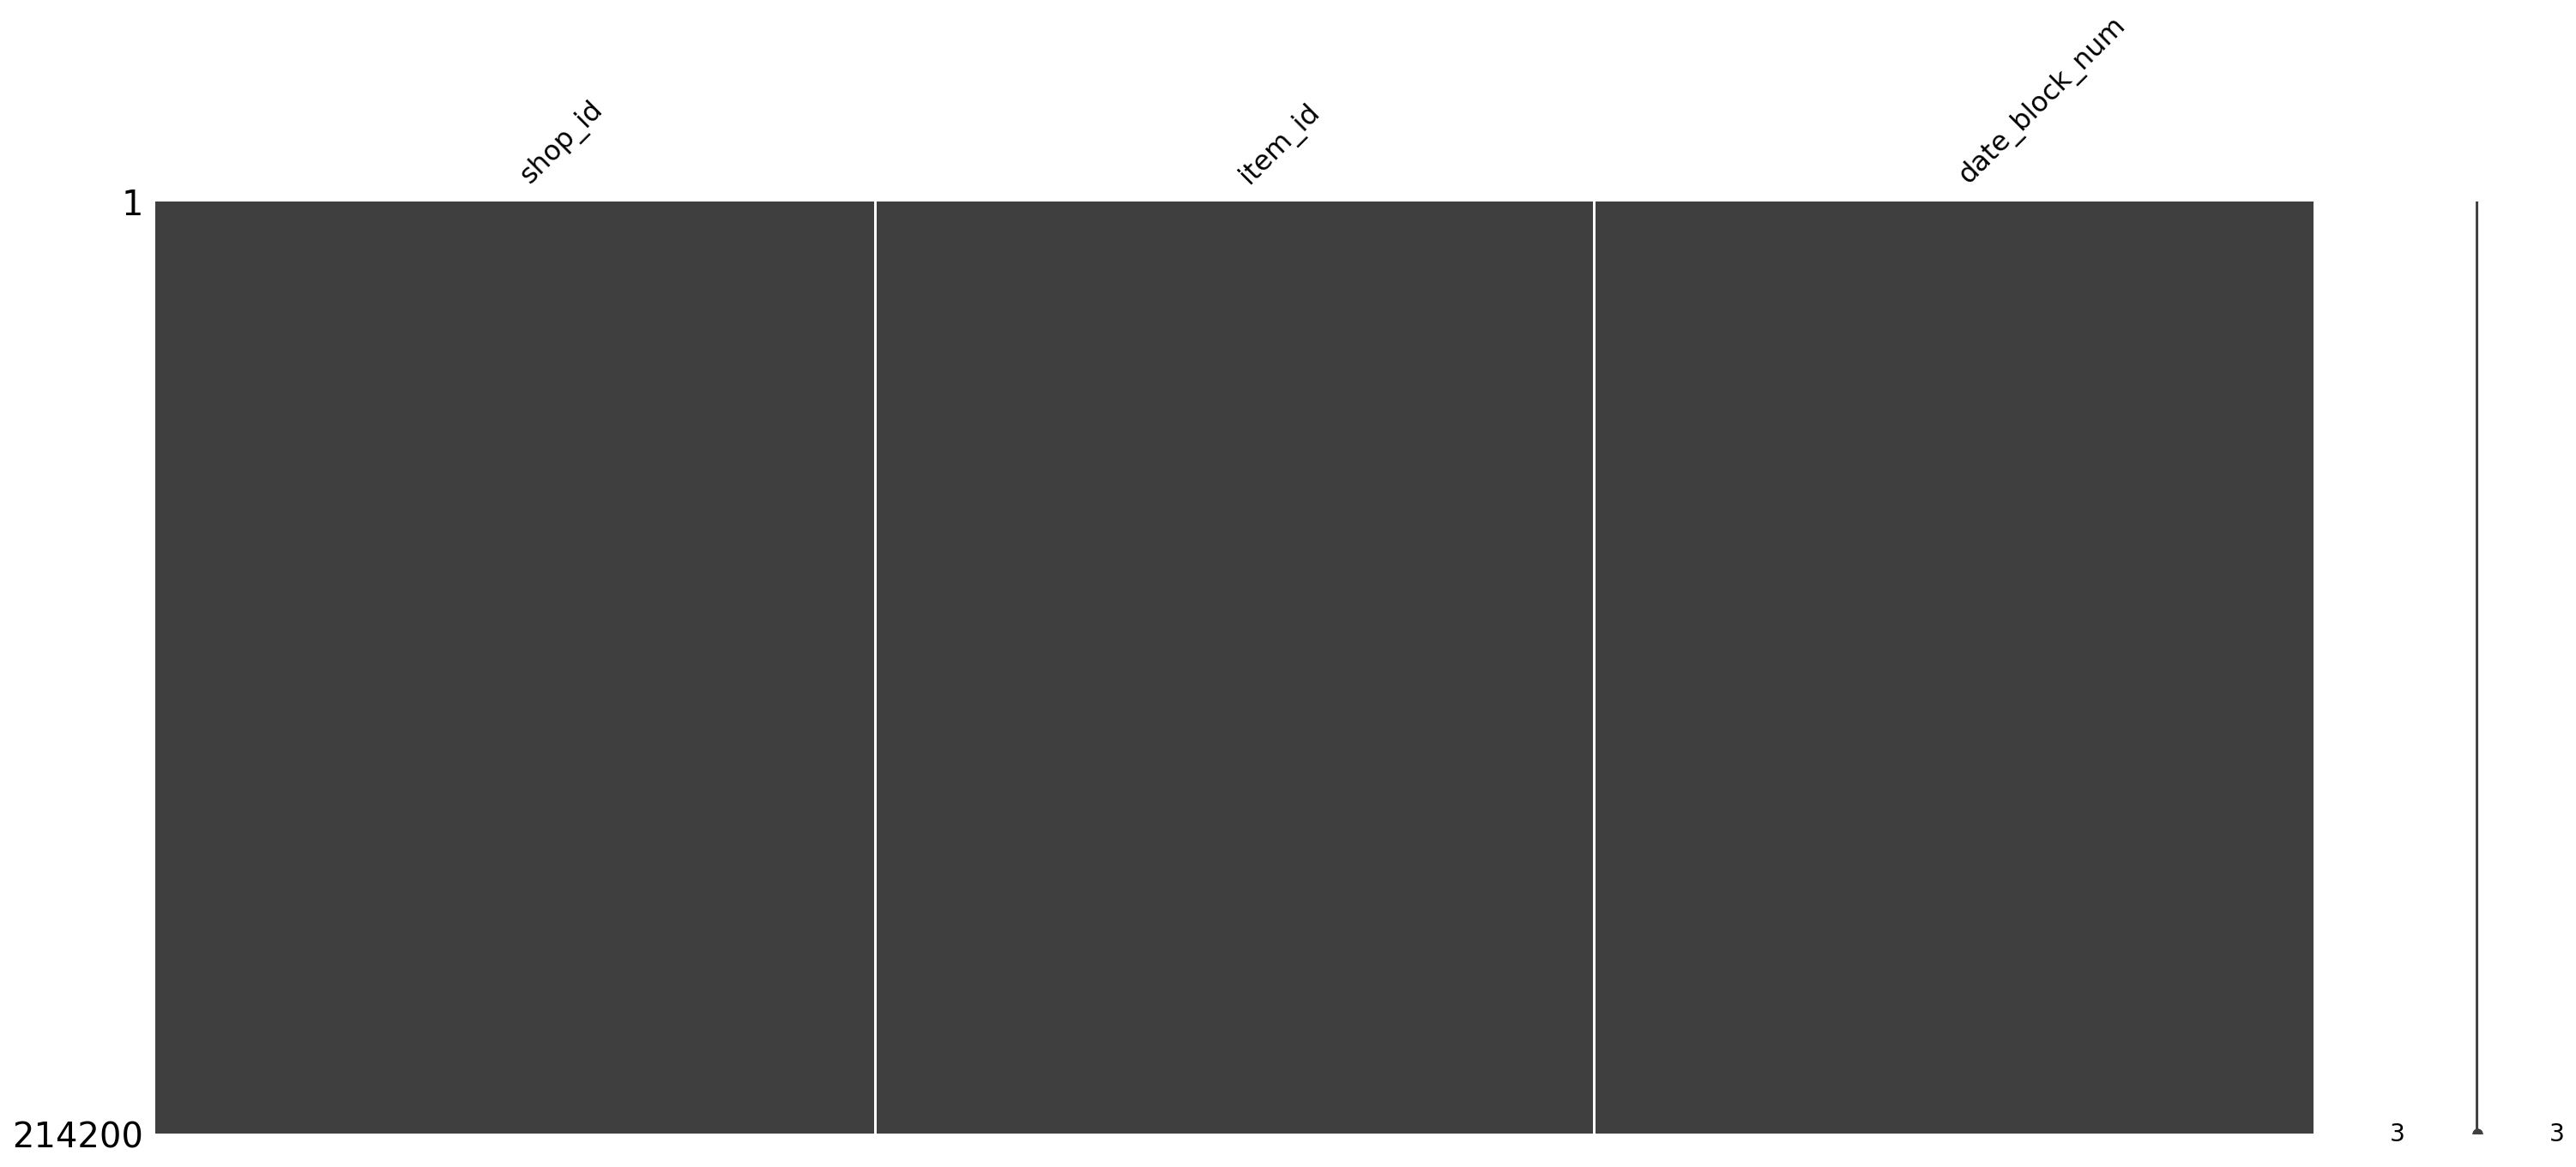

In [11]:
msno.matrix(sub)

In [12]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

date_block_num : 0
shop_id : 0
item_id : 0
item_cnt_day : 0


In [13]:
for c in sub.columns:
    print('{} : {}'.format(c, len(sub.loc[pd.isnull(sub[c]), c].values)))

shop_id : 0
item_id : 0
date_block_num : 0


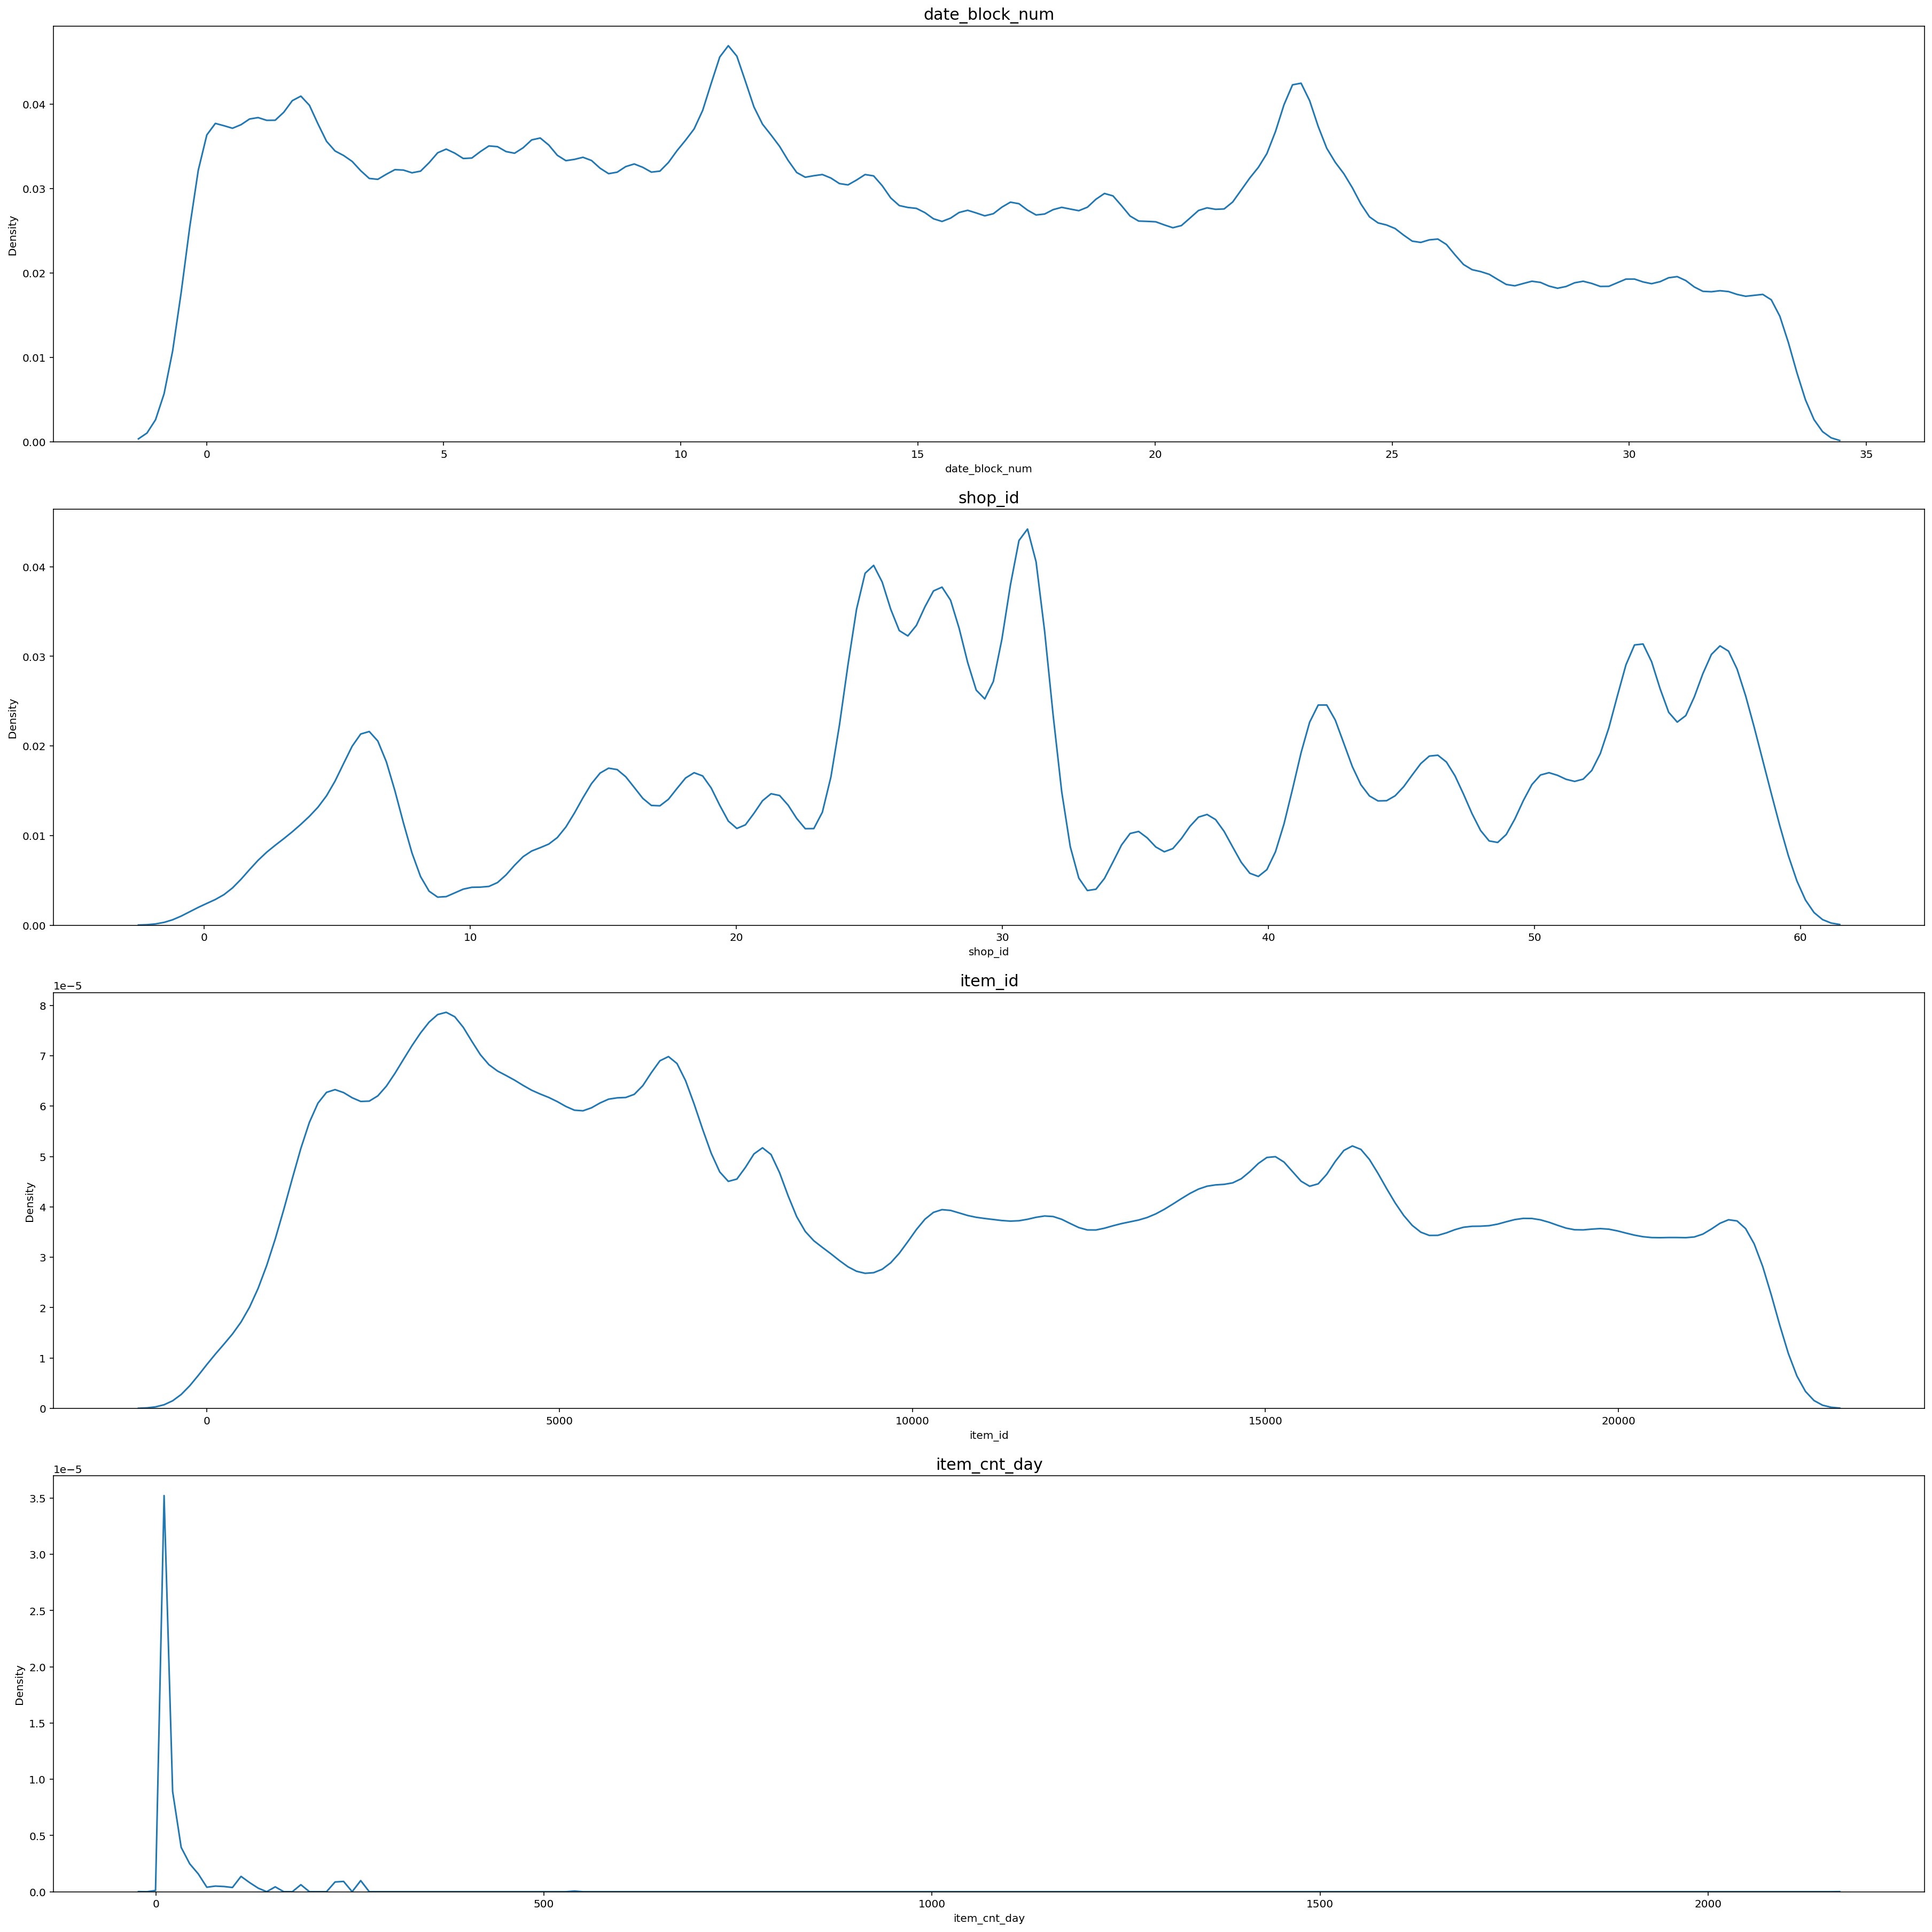

In [14]:
# Í∞ÄÎ°úÏä§ÌÅ¨Î°§ ÎïåÎ¨∏Ïóê Í∑∏ÎûòÌîÑ ÌôïÏù∏Ïù¥ Î∂àÌé∏ÌïòÎã§Î©¥ figsizeÏùò xÍ∞íÏùÑ Ï°∞Ï†àÌï¥ Î≥¥ÏÑ∏Ïöî. 
# constrained_layout=True Í∑∏ÎûòÌîÑÍ∞Ñ Í≤πÏπòÏßÄÏïäÍ≤å ÏµúÏ†ÅÏùò Í∞ÑÍ≤©Ï°∞Ï†à
columns = data.columns
fig, ax = plt.subplots(len(columns), figsize=(25, 25), constrained_layout=True)   

for idx, row in enumerate(range(len(columns))):
    sns.kdeplot(data[columns[idx]], ax=ax[row])
    ax[row].set_title(columns[idx], fontsize=15)

In [15]:
#print('ÏïÑÏù¥ÌÖú Ïàò ÏµúÎåÄÍ∞í', data['item_cnt_day'].max())
#print('ÏïÑÏù¥ÌÖú Ïàò ÏµúÏÜåÍ∞í', data['item_cnt_day'].min())
#temp = data.loc[data['item_price'] < 1000]

data = data.loc[(data['item_cnt_day'] < 250)&(data['item_cnt_day'] >= 0)]

In [18]:
print('ÏïÑÏù¥ÌÖú Ïàò ÏµúÎåÄÍ∞í', data['item_cnt_day'].max())
print('ÏïÑÏù¥ÌÖú Ïàò ÏµúÏÜåÍ∞í', data['item_cnt_day'].min())

ÏïÑÏù¥ÌÖú Ïàò ÏµúÎåÄÍ∞í 242.0
ÏïÑÏù¥ÌÖú Ïàò ÏµúÏÜåÍ∞í 1.0


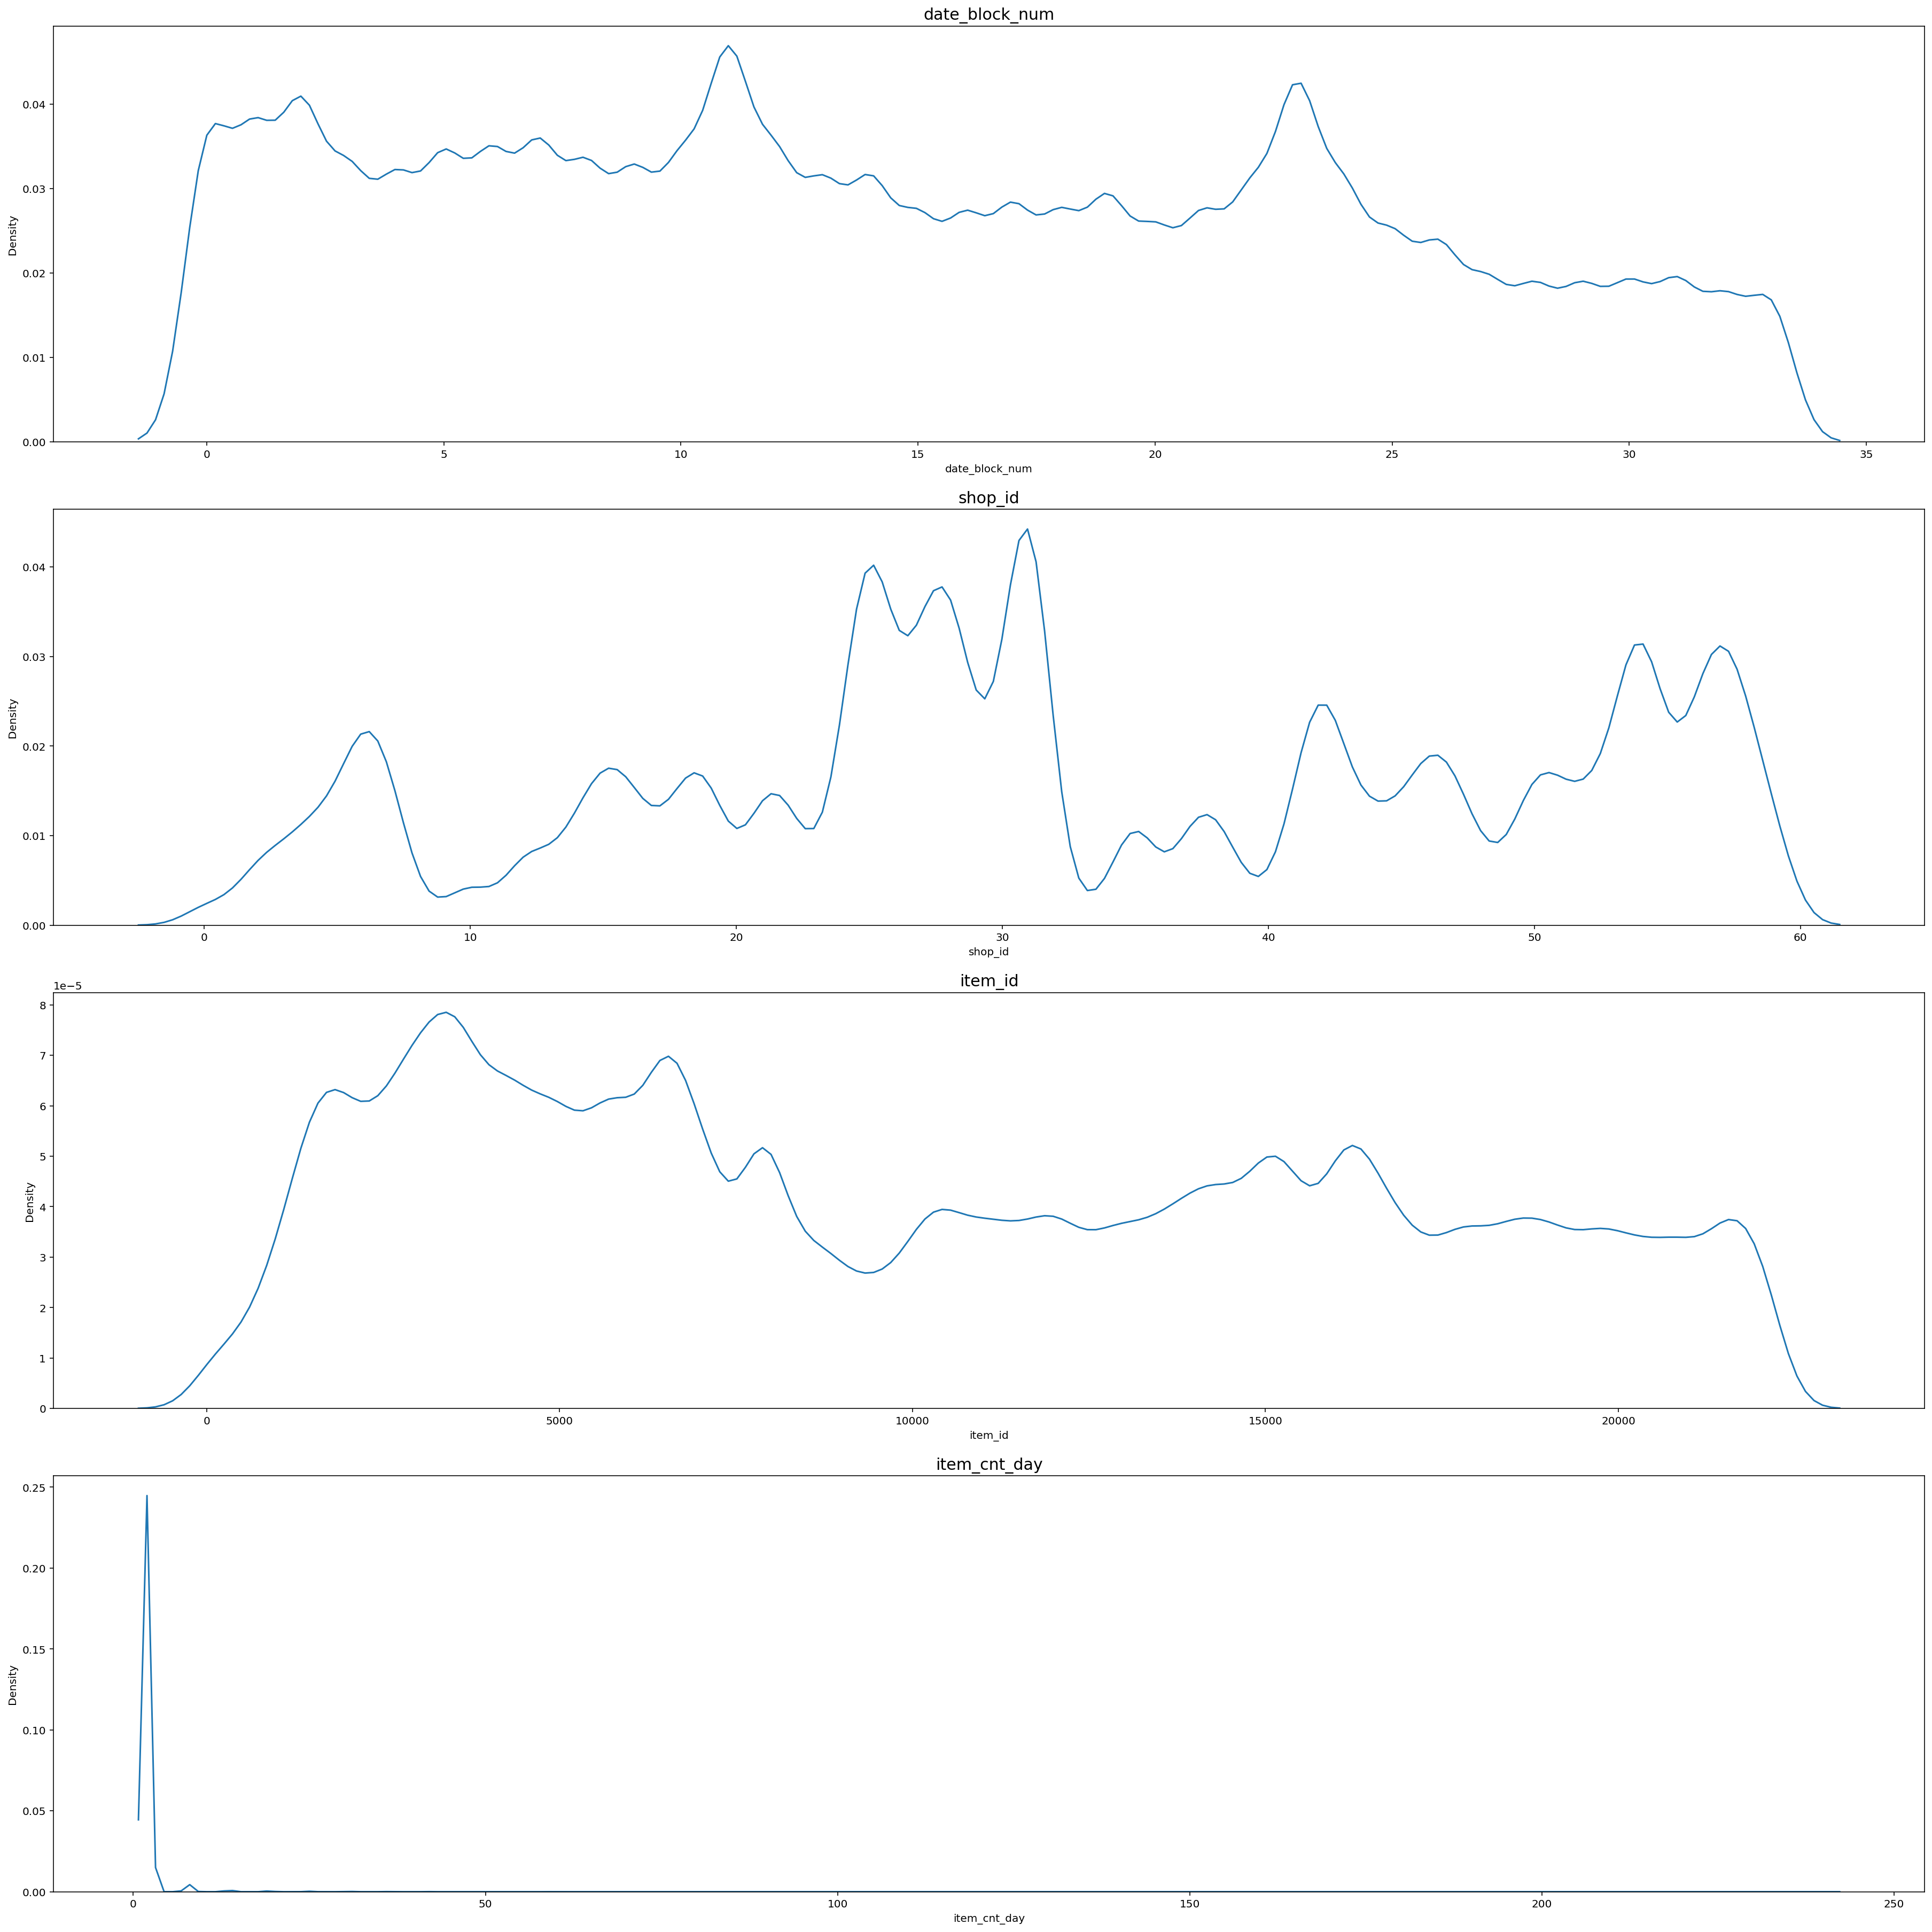

In [17]:
# Í∞ÄÎ°úÏä§ÌÅ¨Î°§ ÎïåÎ¨∏Ïóê Í∑∏ÎûòÌîÑ ÌôïÏù∏Ïù¥ Î∂àÌé∏ÌïòÎã§Î©¥ figsizeÏùò xÍ∞íÏùÑ Ï°∞Ï†àÌï¥ Î≥¥ÏÑ∏Ïöî. 
# constrained_layout=True Í∑∏ÎûòÌîÑÍ∞Ñ Í≤πÏπòÏßÄÏïäÍ≤å ÏµúÏ†ÅÏùò Í∞ÑÍ≤©Ï°∞Ï†à
columns = data.columns
fig, ax = plt.subplots(len(columns), figsize=(25, 25), constrained_layout=True)   

for idx, row in enumerate(range(len(columns))):
    sns.kdeplot(data[columns[idx]], ax=ax[row])
    ax[row].set_title(columns[idx], fontsize=15)

In [ ]:
y = data.loc[(data['item_cnt_day'] < 250)&(data['item_cnt_day'] >= 0)]['item_cnt_day']
del data['item_cnt_day']

In [ ]:
z

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

In [ ]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

In [ ]:
data.columns

In [ ]:
data.columns

In [ ]:
len(data)

In [ ]:
len(y)

In [ ]:
data

In [ ]:
y[0]

In [ ]:
def get_cv_score(model, name):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(data.values)
    print("Model {} CV score : {:.4f}".format(name, np.mean(cross_val_score(model, data.values, y, cv=kfold))))


In [ ]:
get_cv_score(gboost, 'gboost')

In [ ]:
get_cv_score(xgboost, 'xgboost')

In [ ]:
get_cv_score(lightgbm, 'lightgbm')

In [ ]:
print('clear')

In [ ]:
sub.columns

In [ ]:
sub

In [ ]:

def m_pre(model, x, y, sub_x):
    model.fit(x.values, y)
    
    return model.predict(sub_x.values)

print('Ïñçüí¢')

In [ ]:
data

In [ ]:
sub

In [ ]:
len(data)==len(y)

In [ ]:
y_pred = m_pre(gboost, temp, y, sub)

In [ ]:
print(y_pred)

In [ ]:
sns.kdeplot(y_pred)
plt.show()

In [ ]:
result = sub.copy()

In [ ]:
result['item_cnt_day'] = y_pred

In [ ]:
result

In [ ]:
data_dir = './datas'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

In [ ]:
result = pd.DataFrame({
    'ID' : sub_id, 
    'item_cnt_month' : y_pred
})

result.head()

In [ ]:
my_submission_path = join('./datas', 'submission2.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)